In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "./data/data.csv"
df = pd.read_csv(path)

In [3]:
df

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399
...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,29.778412
181796,10,3,10,2,3,97,29.247559
181797,10,3,10,2,3,98,28.796951
181798,10,3,10,2,3,99,28.432936


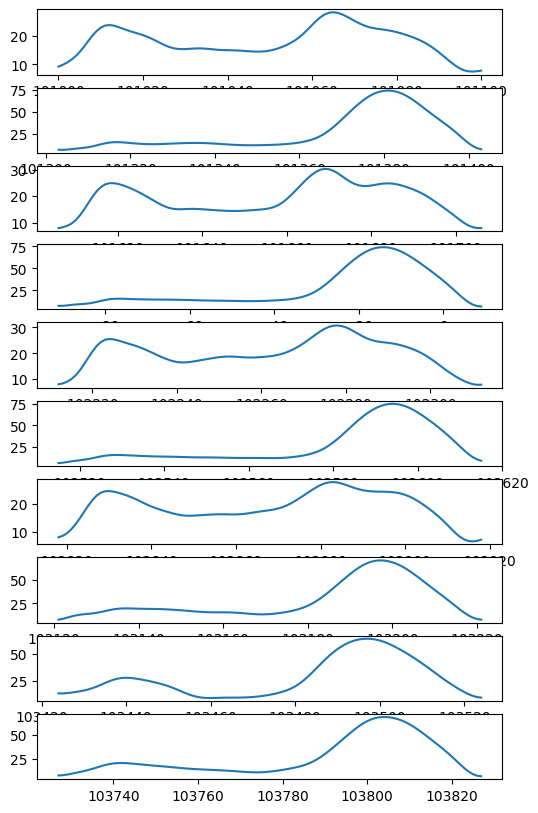

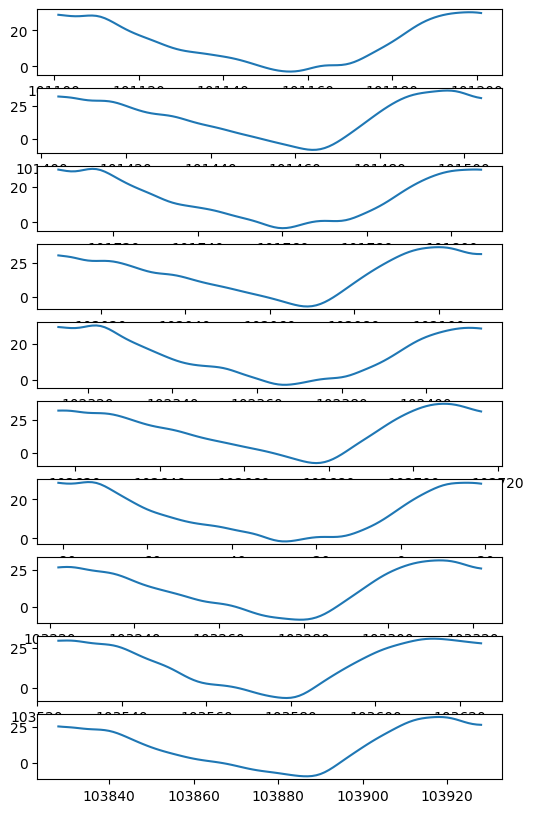

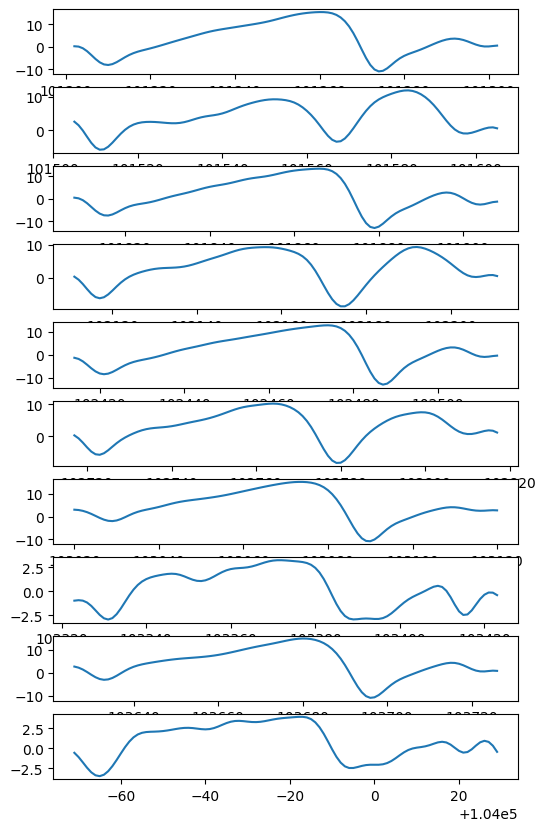

In [4]:
for cat in 10 ** 3 + np.array([0, 1, 2]):
    n_plots = 10
    fig, axes = plt.subplots(n_plots, 1,figsize=(6, 10))

    for i, ax in zip(range(cat, cat + 3 * n_plots, 3), axes.ravel()):
        df.iloc[101 * i:101 * (i+1)].angle.plot(ax=ax)